<a href="https://colab.research.google.com/github/micahandres/Object_Seg/blob/main/v2_stage_1_zero_shot_testing_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GOAL 1: test out how well SAM does with construction lines**

shouldn't be too hard to use my existing "open sketch dataset" -> might involve a bit more work "importing" this data but doable

I will first start with pseudocoding = easier for me to understand:


# Overview

# What SAM Expects
SAM expects:
*   an RGB image as a NumPy array

*   Shape: (H,W,3) = 3 color channels
*   Data Type: uint8 with vals inthe range [0,255]

What Dataset contains
*   .png files that transparency (alpha channel = 4th channel in img that controls transparency); so, some images are RGBA not RGB

What SAM Mask will output
* a list of different mask dictionaries:
  * segmentation = a binary mask (NumPy array) where object is marked
  * area (int) = pixel area of mask
  * bounding box
  * predicted_iou (float) = confidence estimate of mask quality
  * point_coords = where the model thinks the prompt came from
  * stability score (float) how stable the mask is
  * crop box = ?


How to Fine Tune SAM?
* image and prompt encoder would be frozen
* mask encoder = would be making adjustments

How to implement Grounding DINO with SAM?
* [Grounded SAM](https://https://arxiv.org/pdf/2401.14159) (combo of Grounding DINO and SAM) 2024
  1. text prompt class "object" + Image
  2. Grounding DINO = generates bounding boxes
  3. each box + image -> fed into SAM
  4. SAM generates a seg mask per box
  5. returns box, masks, labels, scores

Current Steps:
* We want to have a metric to evaluate the existing model do on the segmentation and, at the same time, we need a ground truth to calculate the metric
  * For this task, we need to see whether SAM can handle construction lines and separate the object ignoring the construction lines
  * Give SAM the images and take the output
  * Calculate how much the object segmentation overlap with the ground truth construction lines and use that as a metric



# Installing Everything

Use nvidia-smi command to make sure we have access to GPU

In [49]:
!nvidia-smi

Thu Jun 26 17:16:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |    2678MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

install SAM and other programs

In [51]:
# installing SAM and other necessary programs
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git' #SAM
!pip install -q jupyter_bbox_widget # can draw and interact with bounding boxes
!pip install -q dataclasses-json # convert dataclasses to JSON to represent masks,points, or settings
!pip install -q supervision==0.23.0 # visualize masks, annotate imgs, etc.

  Preparing metadata (setup.py) ... done


import everything

In [ ]:
import os # for managing file paths and directories
import torch # for using SAM that uses PyTorch
import cv2 # tool for for image processing and  (ex: OpenCV)
import supervision as sv # helps to visualize SAM's output
import numpy as np # format SAM expects of numpy array
import matplotlib.pyplot as plt # for plotting images
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator # the neural network we will use for img segmentation

In [ ]:
# create working directory to manage datasets, images, models
  # checkpoint - saved snao if nidek at a certain point of training, in this case,just to load the model)
  # .pth file = "PyTorch" checkpoint file
  # vit_h = Vision Transformer, Huge
HOME = os.getcwd()

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
CHECKPOINT_FILENAME = "sam_vit_h_4b8939.pth"
CHECKPOINT_PATH  = os.path.join(HOME, "weights", CHECKPOINT_FILENAME)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MODEL_TYPE = "vit_h"

In [ ]:
# loads the SAM model using registry dictionary and moves model to GPU for faster processing
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# enables zero-shot segmentation (aka, no prompting or fine-tuning)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load OpenSketch Data

In [6]:
from zipfile import ZipFile
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for file in files:
        if "Open_Sketch_Dataset" in file:
            print(os.path.join(root, file))

!unzip "/content/drive/MyDrive/Project /Open_Sketch_Dataset copy.zip" -d "/content/Open_Sketch_Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/wobble_surface_Professional4.svg  
  inflating: /content/Open_Sketch_Dataset/__MACOSX/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/._wobble_surface_Professional4.svg  
  inflating: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/flange_Professional6.svg  
  inflating: /content/Open_Sketch_Dataset/__MACOSX/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/svgs_rendering_uniform/._flange_Professional6.svg  
  inflating: /content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/other/sketch2normal_test_datasets/presentation_ridges_silhouettes_centered/s

# Finding Specific Sketches

# Create Functions for Image Pairs and Generating SAM Masks

defines a function that takes:
*   image_path = path to an img file (a sketch)
*   mask_generator = SAM mask
* cv2.IMREAD_UNCHANGED ensures alpha channels (transparency) are preserved if present.
* If the image has 4 channels (RGBA), it's converted to BGR (drops alpha) to make it compatible with later functions.
* Converts the image from OpenCV's default BGR format to RGB, which SAM expects.
* Generates segmentation masks using the SAM model. sam_result contains the masks and metadata for all detected segments.
* detections = sv.Detections.from_sam(sam_result=sam_result)
* mask_annotator = sv.MaskAnnotator()
* Annotates a copy of the original image with the masks (e.g., colored overlays, contours)
* Plots the original image and the annotated image side by side in a grid Helps visually compare the raw input with the segmentation output


In [13]:
DATASET_ROOT = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy"

## Prepare one Concept/Presentation Pair for Subtraction

In [29]:
# presents one concept/presentation pair
# resized as grayscale 1024x1024 arrays for subtraction
# input
  # dataset_root (str): Root path to Open_Sketch_Dataset copy
  # artist_name (str):
  # object_name (str):
  # view (int): 1 or 2 — determines both folder and filename
  # opaque (bool):
# output:
  # concept_img (np.ndarray): Grayscale 1024x1024 concept image
  # presentation_img (np.ndarray): Grayscale 1024x1024 presentation image
  # (concept_path, presentation_path): Path to the org files

def get_padded_sketch_pair(dataset_root, artist, obj, view=1, opaque=True):
    # Build file paths
    view_dir = f"sketches_{'first' if view == 1 else 'second'}_viewpoint"
    prefix = f"view{view}"
    suffix = "_opaque.png" if opaque else ".png"
    base = os.path.join(dataset_root, view_dir, artist, obj)

    concept_path = os.path.join(base, f"{prefix}_concept{suffix}")
    presentation_path = os.path.join(base, f"{prefix}_presentation{suffix}")

    if not (os.path.exists(concept_path) and os.path.exists(presentation_path)):
        print("One or both images not found.")
        return None, None, (concept_path, presentation_path)

    # add padding
    def load_and_pad(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        h, w = img.shape
        top = (1024 - h) // 2
        bottom = 1024 - h - top
        left = (1024 - w) // 2
        right = 1024 - w - left
        return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value = 255)
    return load_and_pad(concept_path), load_and_pad(presentation_path), (concept_path, presentation_path)

    *expects transparency*

In [71]:
concept, presentation, paths = get_padded_sketch_pair(
    "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy",
    artist="Professional1",
    obj="bumps",
    view=1,
    opaque=True
)

print("Concept shape:", concept.shape)
print("Presentation shape:", presentation.shape)
print("File paths:", paths)

Concept shape: (1024, 1024)
Presentation shape: (1024, 1024)
File paths: ('/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png', '/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png')


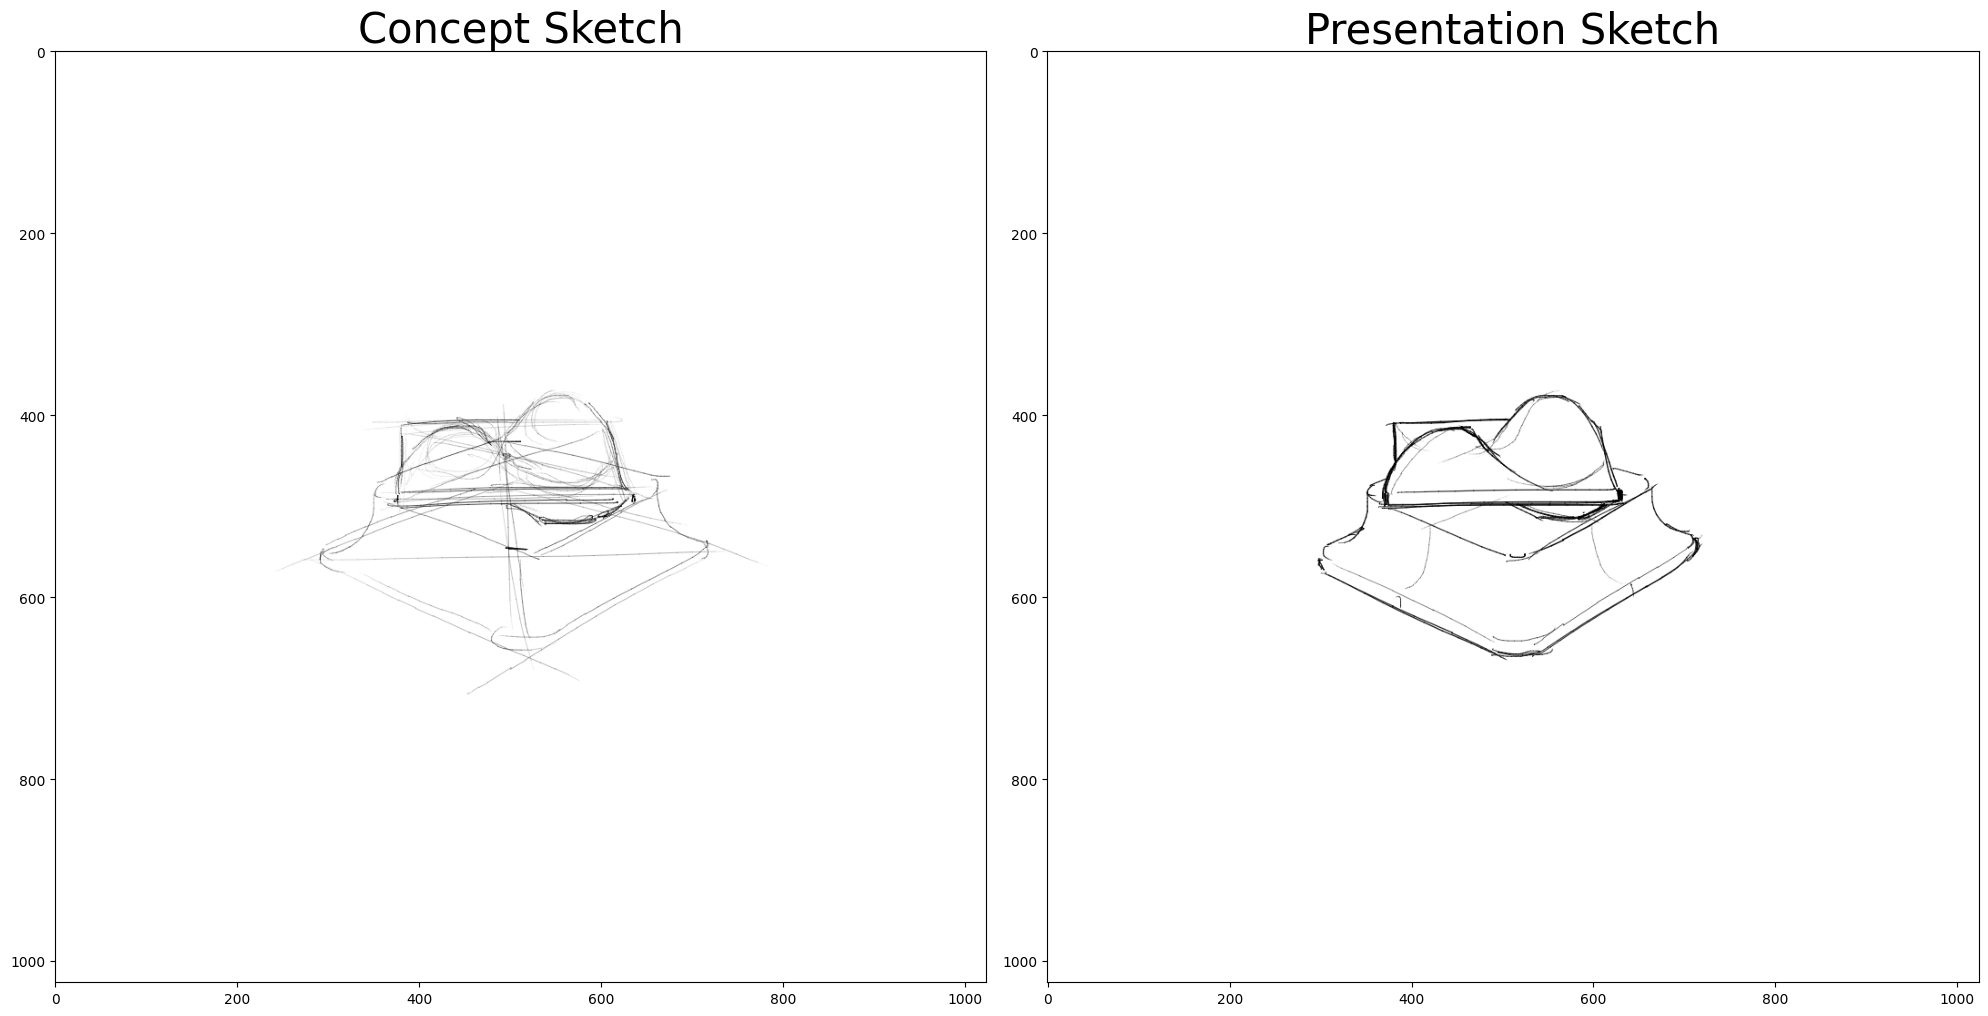

In [40]:
# visualization
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(concept, cmap="gray")
axs[0].set_title("Concept Sketch", fontsize = 30)
axs[1].imshow(presentation, cmap="gray")
axs[1].set_title("Presentation Sketch", fontsize = 30)

plt.tight_layout()
plt.show()

Trying out subtraction to show only the construction lines

In [37]:
construction_lines = cv2.subtract(concept, presentation)
cv2.imwrite("construction_only.png", construction_lines)

True

**Substraction did not work way anticipated.**

Might be bc of:
*   maybe bc construction lines are lighter, they are not detected in the substraction?
*   List item



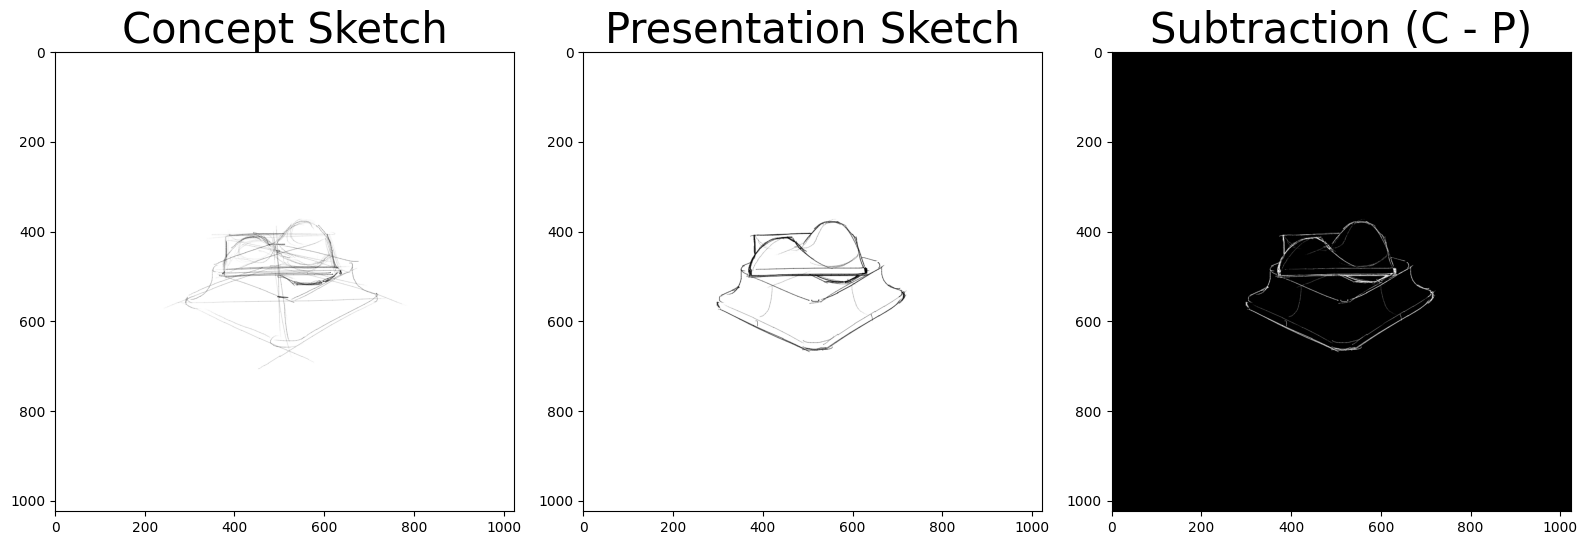

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(16, 7))

axs[0].imshow(concept, cmap="gray")
axs[0].set_title("Concept Sketch", fontsize = 30)
axs[1].imshow(presentation, cmap="gray")
axs[1].set_title("Presentation Sketch", fontsize = 30)
axs[2].imshow(construction_lines, cmap="gray")
axs[2].set_title("Subtraction (C - P)", fontsize = 30)

plt.tight_layout()
plt.show()

## Load Patching Pairs for ALL Sketches

In [47]:
# finds sketch pairs (concept and presentation) and presents as grayscale NumPy arrays
# makes images resized to 1024 x 1024
# makes sketches ready for pixel wise substraction to leave only the construction lines

# arguments:
  # dataset_root
  # viewpoint = choose either 1 or 2
  # opaque (bool)
# returns:
  # concept_gray_images = (NumPy array)
  # presentation_gray_images = (NumPy array)
  # path_pairs = list that contains tuples of [concept_path (str), presentation_path(str)]

import os
import cv2
import numpy as np

import os
import cv2

def get_all_padded_sketch_pairs(dataset_root, view=1, opaque=True):
    view_dir = f"sketches_{'first' if view == 1 else 'second'}_viewpoint"
    prefix = f"view{view}"
    suffix = "_opaque.png" if opaque else ".png"
    base_dir = os.path.join(dataset_root, view_dir)

    all_pairs = []

    def load_and_pad(path):
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      h, w = img.shape
      if h > 1024 or w > 1024:
          scale = 1024 / max(h, w)
          new_size = (int(w * scale), int(h * scale))
          img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
          h, w = img.shape
      top = (1024 - h) // 2
      bottom = 1024 - h - top
      left = (1024 - w) // 2
      right = 1024 - w - left
      return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)

    for artist_folder in os.listdir(base_dir):
        artist_path = os.path.join(base_dir, artist_folder)
        if not os.path.isdir(artist_path):
            continue

        for object_folder in os.listdir(artist_path):
            object_path = os.path.join(artist_path, object_folder)
            if not os.path.isdir(object_path):
                continue

            concept_path = os.path.join(object_path, f"{prefix}_concept{suffix}")
            presentation_path = os.path.join(object_path, f"{prefix}_presentation{suffix}")

            if os.path.exists(concept_path) and os.path.exists(presentation_path):
                concept_img = load_and_pad(concept_path)
                presentation_img = load_and_pad(presentation_path)
                all_pairs.append((concept_img, presentation_img, (concept_path, presentation_path)))
    return all_pairs


testing if get_all_padded_sketch_pair works

In [48]:
pairs = get_all_padded_sketch_pairs(DATASET_ROOT, view=1, opaque=True)
print(f"Total sketch pairs found: {len(pairs)}")

Total sketch pairs found: 107


In [72]:
pairs = get_all_padded_sketch_pairs(
    dataset_root="/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy",
    view=1,
    opaque=True
)

concept_sketches = [pair[0] for pair in pairs]
presentation_sketches = [pair[1] for pair in pairs]

print(f"Concept sketches found: {len(concept_sketches)}")
print(f"Presentation sketches found: {len(presentation_sketches)}")

Concept sketches found: 107
Presentation sketches found: 107




Self Notes:

* cv2.imread(..., cv2.IMREAD_UNCHANGED) keeps the alpha channel (transparency), aka, important for presentation_opaque.png.

* if image has 4 channels -> remove alpha channel for SAM bc it only accepts RGB

* cv2.cvtColor(..., COLOR_BGR2RGB) = convert to RGB since OpenCV reads BGR

* mask_generator.generate = runs SAM to generate masks automatically

* sv.Detections.from_sam = converts output to a format that the Supervision annotator understands

* sv.plot_images_grid = shows original vs. masked image side by side

# Test One Concept and One Presentation Sketch

In [64]:
# Generates and visualizes SAM segmentation masks on a grayscale padded sketch.
# input:
  # image_gray (np.ndarray): Grayscale padded sketch (1024x1024)
  # mask_generator: SAM mask generator instance
# output :
  # annotated_image (np.ndarray): BGR image with segmentation mask overlay

def generate_and_visualize_masks(image_gray, mask_generator):
    image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    sam_result = mask_generator.generate(image_rgb)
    detections = sv.Detections.from_sam(sam_result=sam_result)
    detections.class_id = [0] * len(detections)

    mask_annotator = sv.MaskAnnotator()
    annotated_image = mask_annotator.annotate(
        scene=cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR),
        detections=detections
    )

    return annotated_image

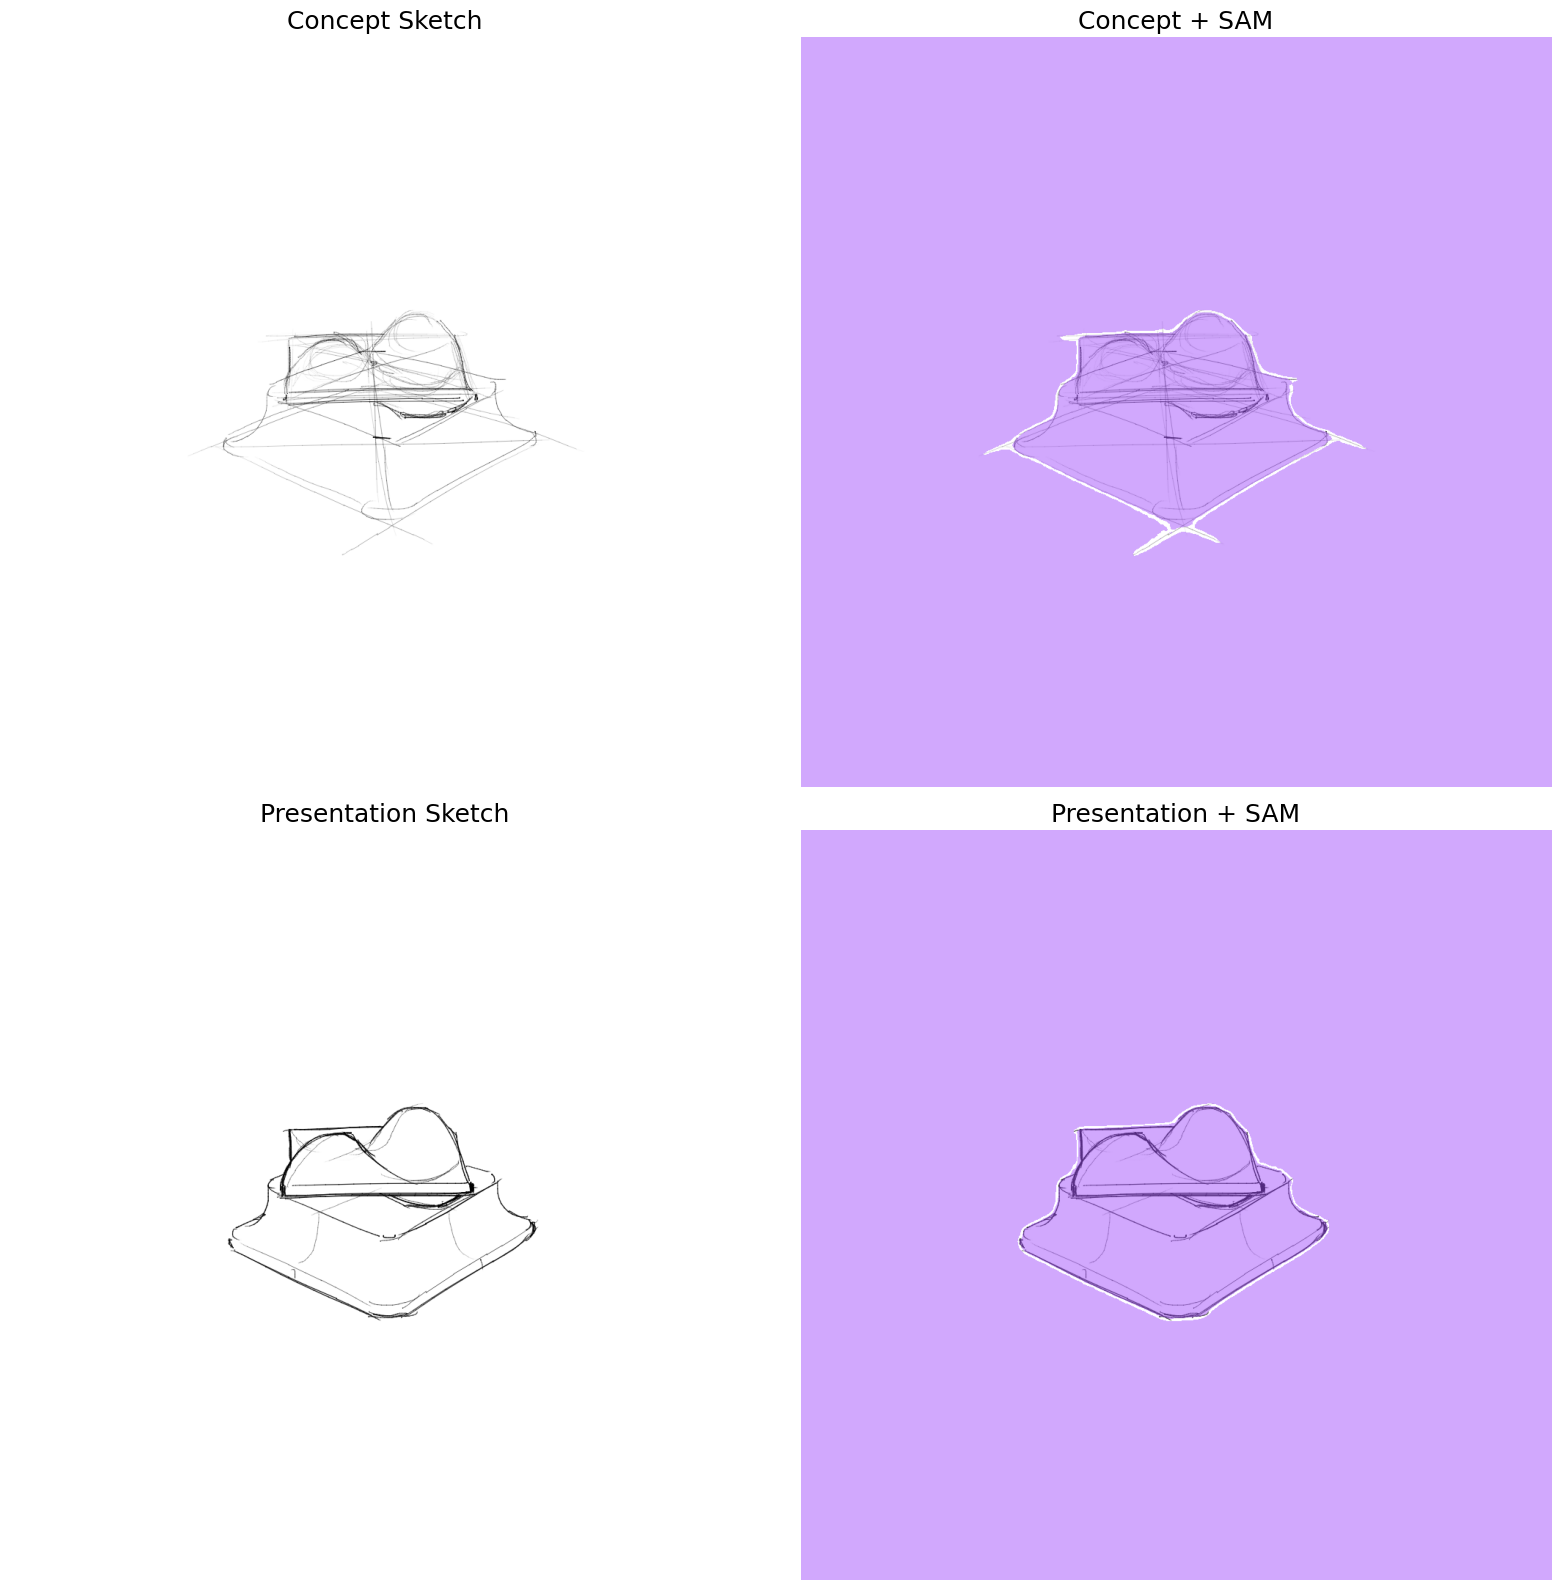

In [68]:
annotated_concept = generate_and_visualize_masks(concept, mask_generator)
annotated_presentation = generate_and_visualize_masks(presentation, mask_generator)

fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Row 1: Concept
axs[0, 0].imshow(concept, cmap="gray")
axs[0, 0].set_title("Concept Sketch", fontsize=18)
axs[0, 0].axis("off")

axs[0, 1].imshow(cv2.cvtColor(annotated_concept, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title("Concept + SAM", fontsize=18)
axs[0, 1].axis("off")

# Row 2: Presentation
axs[1, 0].imshow(presentation, cmap="gray")
axs[1, 0].set_title("Presentation Sketch", fontsize=18)
axs[1, 0].axis("off")

axs[1, 1].imshow(cv2.cvtColor(annotated_presentation, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title("Presentation + SAM", fontsize=18)
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()


In [69]:
print(f"Found {len(concept_sketches)} concept sketches")
print(f"Found {len(presentation_sketches)} presentation sketches")

print("\n Sample Concept Sketch Path:")
print(concept_sketches[0])

print("\n Sample Presentation Sketch Path:")
print(presentation_sketches[0])

NameError: name 'concept_sketches' is not defined

# Testing

black and white version for SAM mask visualization

In [ ]:
def generate_and_visualize_masks_black_and_white(image_path, mask_generator):
    image_bgr = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image_bgr is None:
        raise ValueError(f"Could not read image at {image_path}")

    if len(image_bgr.shape) == 3 and image_bgr.shape[-1] == 4:
        image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_BGRA2BGR)
    elif len(image_bgr.shape) == 2 or image_bgr.shape[-1] != 3:
        raise ValueError("Unsupported image format.")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Run SAM
    sam_result = mask_generator.generate(image_rgb)

    # Create black-and-white binary mask from first result
    binary_mask = sam_result[0]["segmentation"].astype("uint8") * 255

    # Show or save the binary mask
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Black-and-White Mask")
    plt.axis("off")
    plt.show()

    detections = sv.Detections.from_sam(sam_result=sam_result)

    # Fix missing class_id
    detections.class_id = [0] * len(detections)
    mask_annotator = sv.MaskAnnotator()
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Final plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title("SAM Segmentation")
    axs[1].axis("off")
    plt.show()

    return annotated_image

generate_and_visualize_masks_black_and_white(concept_sketches[0], mask_generator)
generate_and_visualize_masks_black_and_white(presentation_sketches[0], mask_generator)

## Trial 1: simple substract
THIS IS WRONG, there should be much more lines for extracted construction lines

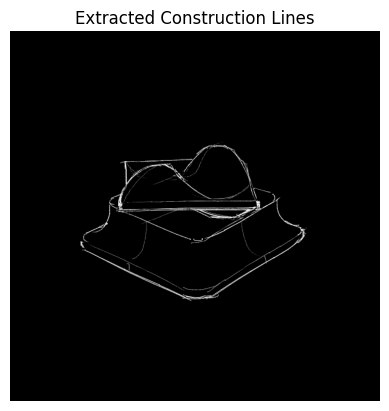

In [ ]:
full_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png"
clean_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png"

# Load grayscale images
full = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)

# Ensure both loaded and same shape
if full is None or clean is None:
    print("One or both images couldn't be loaded.")
elif full.shape != clean.shape:
    print("Image shapes don't match:", full.shape, clean.shape)
else:
    # Subtract to get construction-only lines
    construction_only = cv2.subtract(full, clean)

    # Show result
    plt.imshow(construction_only, cmap="gray")
    plt.title("Extracted Construction Lines")
    plt.axis("off")
    plt.show()


## Trial 2: binarize and threshold
Trying to boost the opacity of the construction lines to make it easier

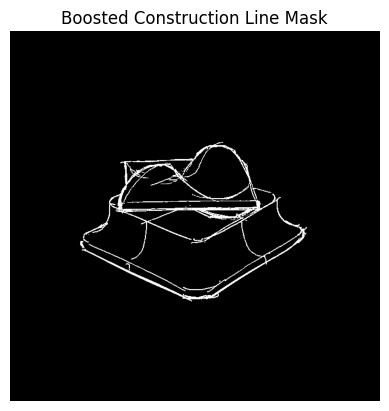

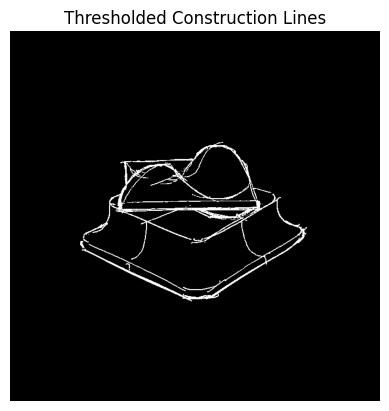

In [ ]:
construction_only = cv2.subtract(full, clean)
# Stretch the difference to full intensity
enhanced = cv2.convertScaleAbs(construction_only, alpha=100.0, beta=0)  # alpha 2–5 is typical

plt.imshow(enhanced, cmap="gray")
plt.title("Boosted Construction Line Mask")
plt.axis("off")
plt.show()

clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
clahe_applied = clahe.apply(construction_only)

_, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY)  # 20–50 is typical range

plt.imshow(thresholded, cmap="gray")
plt.title("Thresholded Construction Lines")
plt.axis("off")
plt.show()

## Trial 3: increase threshold

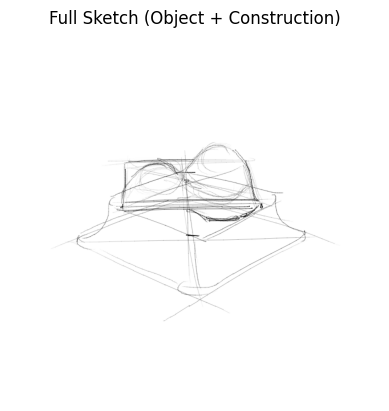

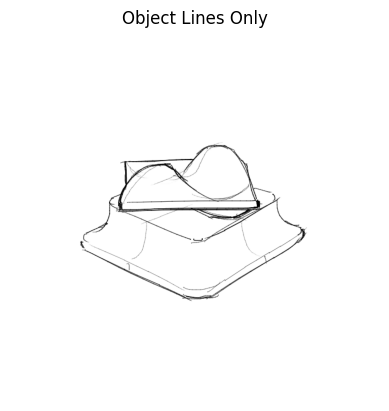

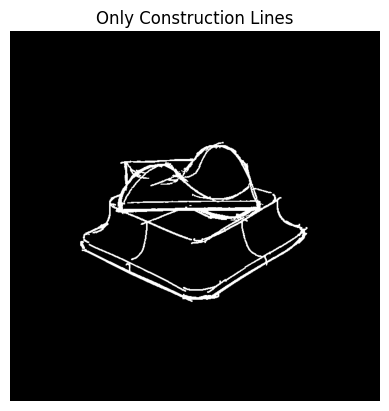

In [ ]:
full_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png"
clean_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png"
full = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(full, cmap="gray")
plt.title("Full Sketch (Object + Construction)")
plt.axis("off")
plt.show()

clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(clean, cmap="gray")
plt.title("Object Lines Only")
plt.axis("off")
plt.show()

# Subtract object-only from full sketch
construction_raw = cv2.subtract(full, clean)

# Boost faint lines
boosted = cv2.convertScaleAbs(construction_raw, alpha=15.0)

# Optional CLAHE
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
boosted = clahe.apply(boosted)

# Threshold to clean up noise
_, construction_mask = cv2.threshold(boosted, 5, 255, cv2.THRESH_BINARY)

# Optional dilation
kernel = np.ones((2,2), np.uint8)
construction_final = cv2.dilate(construction_mask, kernel, iterations=1)

# Show
plt.imshow(construction_final, cmap="gray")
plt.title("Only Construction Lines")
plt.axis("off")
plt.show()

## Trial 4: Seems to only show construction lines only

✅ Images loaded and same size: (691, 691)


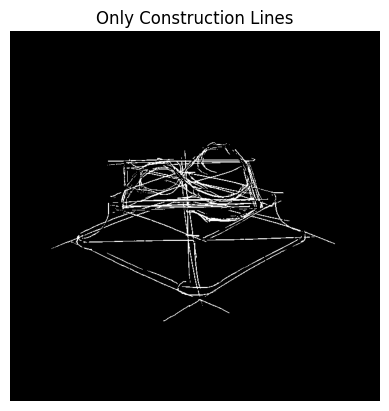

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths
full_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png"
clean_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png"

# Load and convert to grayscale
full = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)

# Check if images loaded successfully
if full is None or clean is None:
    print("One or both images could not be loaded.")
    print("Full path:", full_path, "| Loaded:", full is not None)
    print("Clean path:", clean_path, "| Loaded:", clean is not None)
else:
    # Now safe to access shape
    if full.shape != clean.shape:
        print("Shape mismatch:", full.shape, clean.shape)
    else:
        print("Images loaded and same size:", full.shape)

# Ensure same size
if full.shape != clean.shape:
    print("Shape mismatch:", full.shape, clean.shape)

# Invert so lines are white on black
full_inv = cv2.bitwise_not(full)
clean_inv = cv2.bitwise_not(clean)

# Subtract to isolate construction lines
construction = cv2.subtract(full_inv, clean_inv)

# Optional: Boost contrast
construction_boost = cv2.convertScaleAbs(construction, alpha=2.0, beta=0)

# Optional: Threshold to binarize
_, construction_thresh = cv2.threshold(construction_boost, 25, 255, cv2.THRESH_BINARY)

# Display result
plt.imshow(construction_thresh, cmap='gray')
plt.title("Only Construction Lines")
plt.axis('off')
plt.show()

## Trial 5: only object lines shown

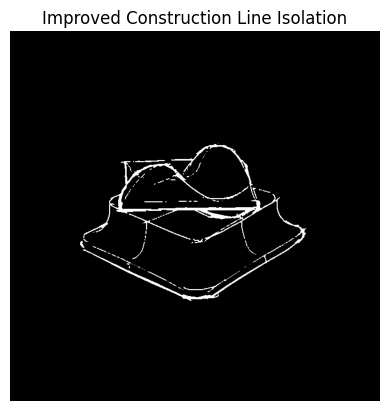

In [ ]:
# Normalize to [0, 1]
full_f = full.astype(np.float32) / 255.0
clean_f = clean.astype(np.float32) / 255.0

# Subtract and threshold
diff = np.clip(full_f - clean_f, 0, 1)
diff_bin = (diff > 0.05).astype(np.uint8) * 255

# Optional smoothing
diff_bin = cv2.medianBlur(diff_bin, 3)

# Show result
plt.imshow(diff_bin, cmap='gray')
plt.title("Improved Construction Line Isolation")
plt.axis('off')
plt.show()

## Trial 6: only construction lines but looks weird

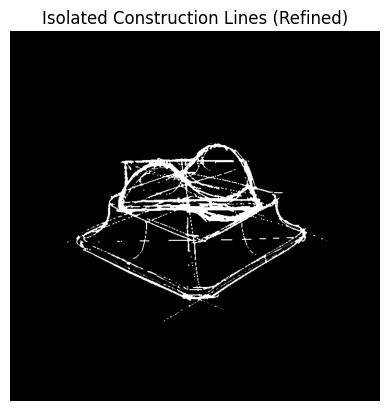

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Normalize to float32 for accurate subtraction
full_f = full.astype(np.float32) / 255.0
clean_f = clean.astype(np.float32) / 255.0

# Use absolute difference to detect variation (construction lines)
diff = np.abs(full_f - clean_f)

# Apply threshold to suppress shared lines (object lines)
mask = (diff > 0.08).astype(np.uint8) * 255

# Optional: clean up noise
mask = cv2.medianBlur(mask, 3)

# Display
plt.imshow(mask, cmap='gray')
plt.title("Isolated Construction Lines (Refined)")
plt.axis('off')
plt.show()


## Trial 7:

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

full_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_concept_opaque.png"
clean_path = "/content/Open_Sketch_Dataset/Open_Sketch_Dataset copy/sketches_first_viewpoint/Professional1/bumps/view1_presentation_opaque.png"

# Load images (BGR format by default)
full_img = cv2.imread(full_path)
clean_img = cv2.imread(clean_path)

# Convert to RGB for correct color display
full_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
clean_rgb = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(full_rgb)
axs[0].set_title("Concept Sketch")
axs[0].axis("off")

axs[1].imshow(clean_rgb)
axs[1].set_title("Presentation Sketch")
axs[1].axis("off")

plt.tight_layout()
plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Trial 8: